# Importing Libraries

In [1]:
import dlib
import cv2
import os
import re
import json
from pylab import *
from PIL import Image, ImageChops, ImageEnhance
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import splitfolders
import PIL
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
import glob
import cv2
import seaborn as sns
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, LSTM
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os, shutil
import sys
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dropout, Dense,LSTM, Reshape
import glob as gb
import warnings
warnings.filterwarnings('ignore')

# Preparing the dataset

In [2]:
real_videos_folder = 'Dataset/Real'
fake_videos_folder = 'Dataset/Fake'

def process_videos(video_folder, output_folder):
    list_of_data = [f for f in os.listdir(video_folder) if f.endswith('.mp4')]
    detector = dlib.get_frontal_face_detector()

    for vid in list_of_data:
        count = 0
        cap = cv2.VideoCapture(os.path.join(video_folder, vid))
        frameRate = cap.get(5)

        while cap.isOpened():
            frameId = cap.get(1)
            ret, frame = cap.read()

            if not ret or frame is None or frame.size == 0:
                break

            if frameId % ((int(frameRate) + 1) * 1) == 0:
                face_rects, _, _ = detector.run(frame, 0)
                
                for i, d in enumerate(face_rects):
                    x1 = d.left()
                    y1 = d.top()
                    x2 = d.right()
                    y2 = d.bottom()
                    crop_img = frame[y1:y2, x1:x2]

                    if crop_img.size != 0:
                        resized_img = cv2.resize(crop_img, (128, 128))
                        cv2.imwrite(os.path.join(output_folder, vid.split('.')[0] + '_' + str(count) + '.png'), resized_img)
                        count += 1

In [3]:
process_videos(real_videos_folder, 'data/real')

In [4]:
process_videos(fake_videos_folder, 'data/fake')

# Loading the dataset

In [5]:

class config:
    
    data_path = 'data/'
    
    path_train = "./output/train"
    path_test = "./output/test"

In [6]:
splitfolders.ratio(config.data_path, output="output", seed=101, ratio=(.8, .2))

# EDA

In [7]:
BATCH_SIZE = 64
IMAGE_SHAPE = (128, 128)

In [8]:
TRAIN_PATH = "output/train"
VAL_PATH = "output/val"

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_gen = datagen.flow_from_directory(directory = TRAIN_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

val_gen = datagen.flow_from_directory(directory = VAL_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

Found 7850 images belonging to 2 classes.
Found 1964 images belonging to 2 classes.


# Data Visualization

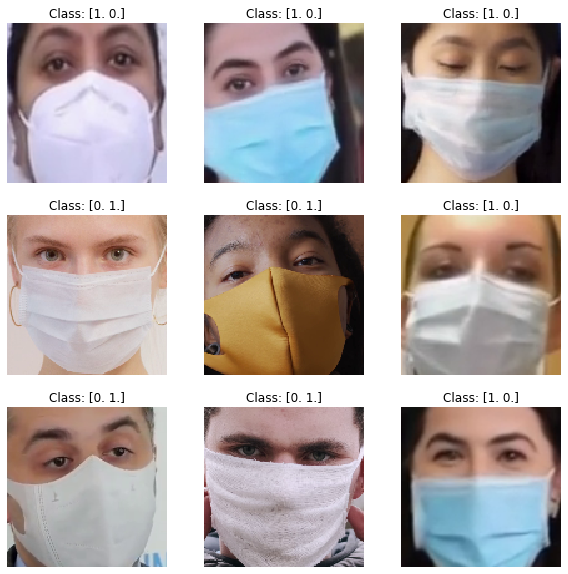

In [10]:
def plot_images(generator, num_images=9):
    
    images, labels = generator.next()

    
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Class: {labels[i]}')
        plt.axis('off')
    
    plt.show()


plot_images(train_gen)



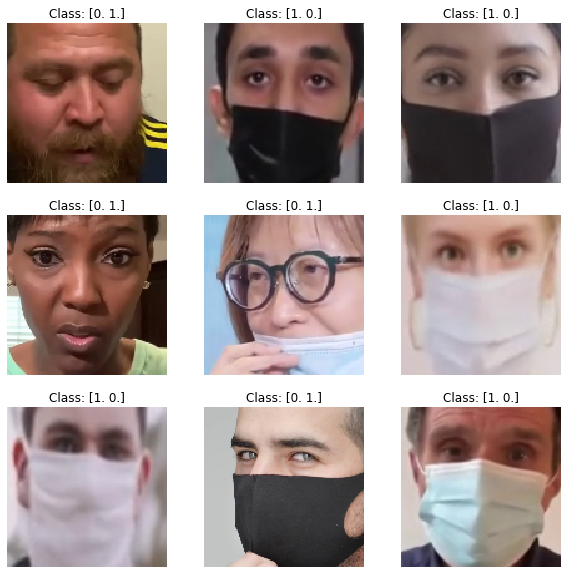

In [11]:
plot_images(val_gen)

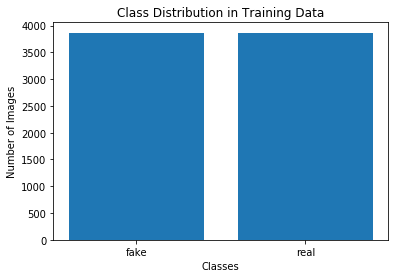

In [12]:
class_counts = np.sum(train_gen.labels, axis=0)
classes = list(train_gen.class_indices.keys())

plt.bar(classes, class_counts)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Data')
plt.show()

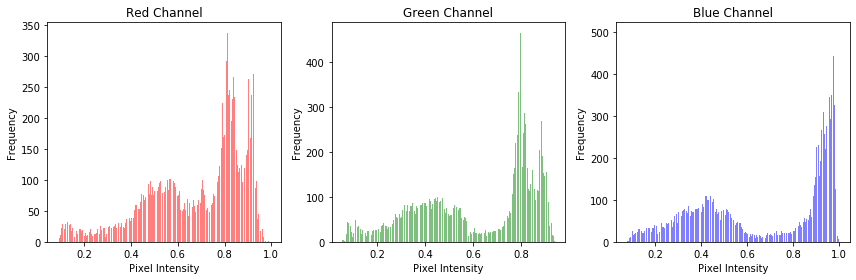

In [13]:
def plot_pixel_intensity(image):
    plt.figure(figsize=(12, 4))

   
    plt.subplot(1, 3, 1)
    plt.hist(image[:, :, 0].ravel(), bins=256, color='red', alpha=0.5, rwidth=0.8)
    plt.title('Red Channel')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    
    plt.subplot(1, 3, 2)
    plt.hist(image[:, :, 1].ravel(), bins=256, color='green', alpha=0.5, rwidth=0.8)
    plt.title('Green Channel')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    
    plt.subplot(1, 3, 3)
    plt.hist(image[:, :, 2].ravel(), bins=256, color='blue', alpha=0.5, rwidth=0.8)
    plt.title('Blue Channel')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


sample_image = train_gen[0][0][0]  
plot_pixel_intensity(sample_image)

# Model Building

### Inception-ResNet-v2

In [14]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [15]:
inc = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
123/123 [==============================] - 23s 104ms/step - loss: 0.4271 - accuracy: 0.8975 - f1_score: 0.8975 - recall_m: 0.8975 - precision_m: 0.8975 - specificity_m: 0.8975 - sensitivity_m: 0.8975 - mae: 0.1431 - mse: 0.0782 - val_loss: 0.7950 - val_accuracy: 0.6380 - val_f1_score: 0.6387 - val_recall_m: 0.6387 - val_precision_m: 0.6387 - val_specificity_m: 0.6387 - val_sensitivity_m: 0.6387 - val_mae: 0.3361 - val_mse: 0.2556
Epoch 2/50
123/123 [==============================] - 10s 81ms/step - loss: 0.1189 - accuracy: 0.9754 - f1_score: 0.9754 - recall_m: 0.9754 - precision_m: 0.9754 - specificity_m: 0.9754 - sensitivity_m: 0.9754 - mae: 0.0453 - mse: 0.0213 - val_loss: 5.3479 - val_accuracy: 0.8737 - val_f1_score: 0.8736 - val_recall_m: 0.8736 - val_precision_m: 0.8736 - val_specificity_m: 0.8736 - val_sensitivity_m: 0.8736 - val_mae: 0.1329 - val_mse: 0.1155
Epoch 3/50
123/123 [==============================] - 10s 80ms/step - loss: 0.0938 - accuracy: 0.9815 - f1_scor

In [17]:
model.save('models/Inceptionresnet_v2.h5')

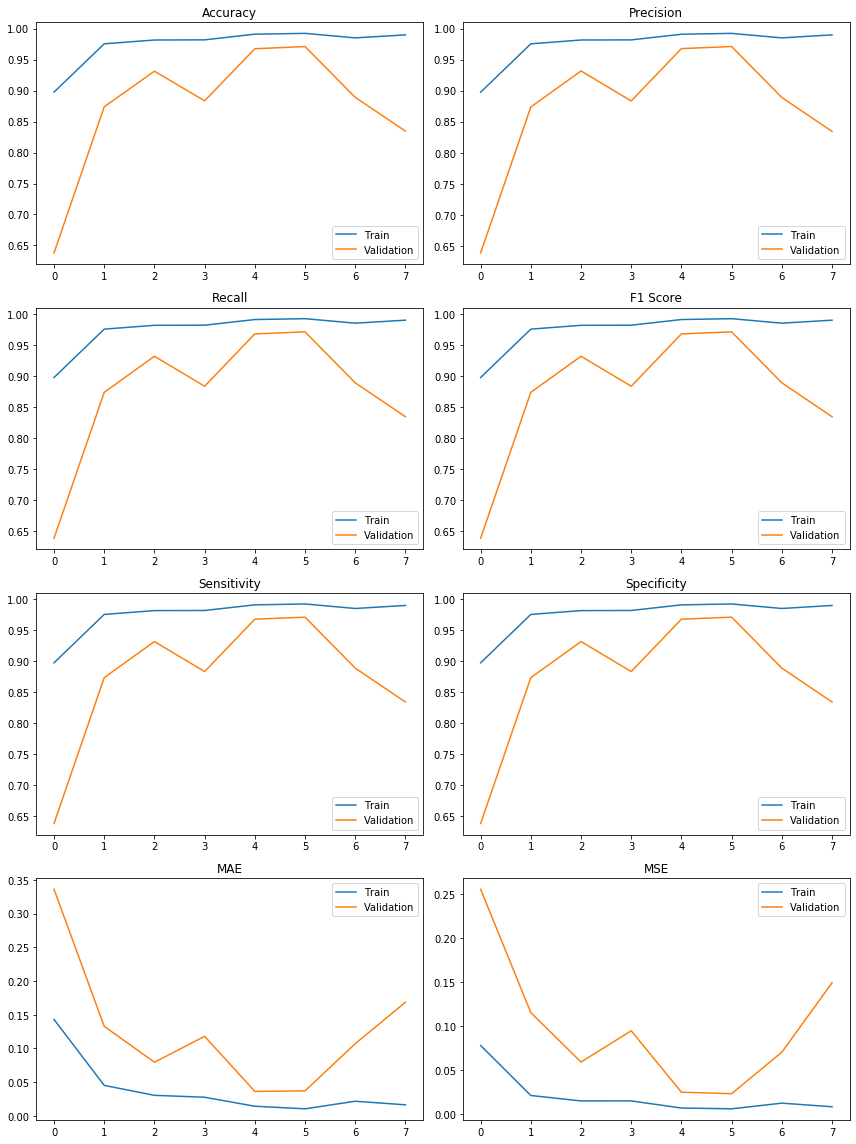

In [18]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

31/31 [==============================] - 1s 37ms/step - loss: 207.9218 - accuracy: 0.8345 - f1_score: 0.8348 - recall_m: 0.8348 - precision_m: 0.8348 - specificity_m: 0.8348 - sensitivity_m: 0.8348 - mae: 0.1679 - mse: 0.1487


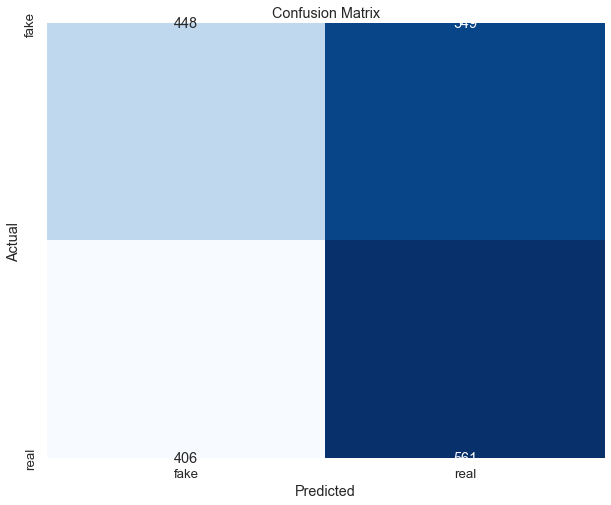

In [19]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [20]:
a = history.history['accuracy'][-1]
f = history.history['f1_score'][-1]
p = history.history['precision_m'][-1]
r = history.history['recall_m'][-1]
mae = history.history['mae'][-1]
mse = history.history['mse'][-1]
specificity = history.history['specificity_m'][-1]  
sensitivity = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a * 100))
print('Precision = ' + str(p * 100))
print('F1 Score = ' + str(f * 100))
print('Recall = ' + str(r * 100))
print('MAE = ' + str(mae))
print('MSE = ' + str(mse))
print('Sensitivity = ' + str(sensitivity * 100))  
print('Specificity = ' + str(specificity * 100))

Accuracy = 98.98089170455933
Precision = 98.98374080657959
F1 Score = 98.98374080657959
Recall = 98.98374080657959
MAE = 0.016432957723736763
MSE = 0.008541797287762165
Sensitivity = 98.98374080657959
Specificity = 98.98374080657959


# VGG19

In [21]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [22]:
inc = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [23]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
123/123 [==============================] - 11s 71ms/step - loss: 0.9118 - accuracy: 0.5129 - f1_score: 0.5126 - recall_m: 0.5126 - precision_m: 0.5126 - specificity_m: 0.5126 - sensitivity_m: 0.5126 - mae: 0.4971 - mse: 0.2619 - val_loss: 0.6963 - val_accuracy: 0.4924 - val_f1_score: 0.4929 - val_recall_m: 0.4929 - val_precision_m: 0.4929 - val_specificity_m: 0.4929 - val_sensitivity_m: 0.4929 - val_mae: 0.5005 - val_mse: 0.2515
Epoch 2/50
123/123 [==============================] - 7s 56ms/step - loss: 0.6965 - accuracy: 0.4921 - f1_score: 0.4921 - recall_m: 0.4921 - precision_m: 0.4921 - specificity_m: 0.4921 - sensitivity_m: 0.4921 - mae: 0.5003 - mse: 0.2516 - val_loss: 0.6942 - val_accuracy: 0.4924 - val_f1_score: 0.4913 - val_recall_m: 0.4913 - val_precision_m: 0.4913 - val_specificity_m: 0.4913 - val_sensitivity_m: 0.4913 - val_mae: 0.5004 - val_mse: 0.2505
Epoch 3/50
123/123 [==============================] - 7s 56ms/step - loss: 0.7118 - accuracy: 0.5164 - f1_score: 

In [24]:
model.save('models/vgg19.h5')

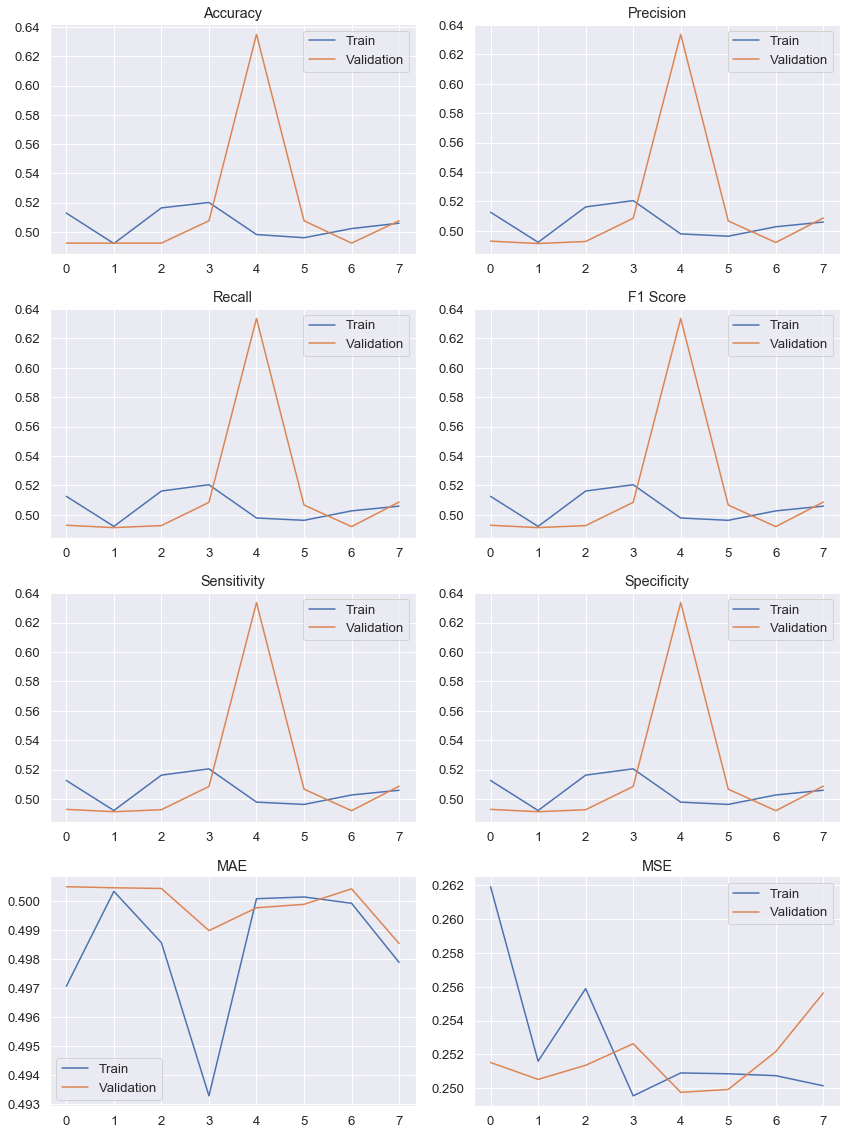

In [25]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

31/31 [==============================] - 1s 35ms/step - loss: 0.7050 - accuracy: 0.5076 - f1_score: 0.5066 - recall_m: 0.5066 - precision_m: 0.5066 - specificity_m: 0.5066 - sensitivity_m: 0.5066 - mae: 0.4989 - mse: 0.2560


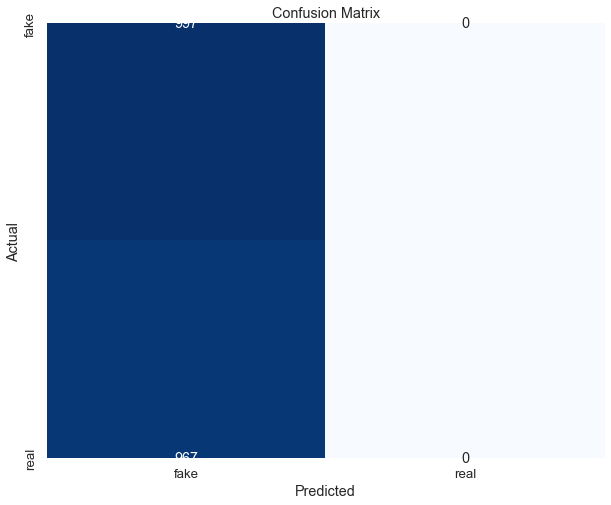

In [26]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [27]:
a1 = history.history['accuracy'][-1]
f1 = history.history['f1_score'][-1]
p1 = history.history['precision_m'][-1]
r1 = history.history['recall_m'][-1]
mae1 = history.history['mae'][-1]
mse1 = history.history['mse'][-1]
specificity1 = history.history['specificity_m'][-1]  
sensitivity1 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a1 * 100))
print('Precision = ' + str(p1 * 100))
print('F1 Score = ' + str(f1 * 100))
print('Recall = ' + str(r1 * 100))
print('MAE = ' + str(mae1))
print('MSE = ' + str(mse1))
print('Sensitivity = ' + str(sensitivity1 * 100))  
print('Specificity = ' + str(specificity1 * 100))

Accuracy = 50.5987286567688
Precision = 50.5903959274292
F1 Score = 50.5903959274292
Recall = 50.5903959274292
MAE = 0.4978759288787842
MSE = 0.2501467764377594
Sensitivity = 50.5903959274292
Specificity = 50.5903959274292


# CNN

In [28]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)) 

In [29]:
model = models.Sequential() 


model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=[128, 128, 3]))
model.add(MaxPooling2D(2, ))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))


model.add(Flatten())


model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_203 (Conv2D)          (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [30]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
123/123 [==============================] - 6s 47ms/step - loss: 0.5458 - accuracy: 0.7271 - f1_score: 0.7273 - recall_m: 0.7273 - precision_m: 0.7273 - specificity_m: 0.7273 - sensitivity_m: 0.7273 - mae: 0.3548 - mse: 0.1775 - val_loss: 0.3183 - val_accuracy: 0.8681 - val_f1_score: 0.8674 - val_recall_m: 0.8674 - val_precision_m: 0.8674 - val_specificity_m: 0.8674 - val_sensitivity_m: 0.8674 - val_mae: 0.2019 - val_mse: 0.0980
Epoch 2/50
123/123 [==============================] - 6s 45ms/step - loss: 0.2856 - accuracy: 0.8846 - f1_score: 0.8845 - recall_m: 0.8845 - precision_m: 0.8845 - specificity_m: 0.8845 - sensitivity_m: 0.8845 - mae: 0.1827 - mse: 0.0870 - val_loss: 0.2611 - val_accuracy: 0.8982 - val_f1_score: 0.8983 - val_recall_m: 0.8983 - val_precision_m: 0.8983 - val_specificity_m: 0.8983 - val_sensitivity_m: 0.8983 - val_mae: 0.1598 - val_mse: 0.0772
Epoch 3/50
123/123 [==============================] - 6s 45ms/step - loss: 0.2036 - accuracy: 0.9225 - f1_score: 0

In [31]:
model.save('models/cnn.h5')

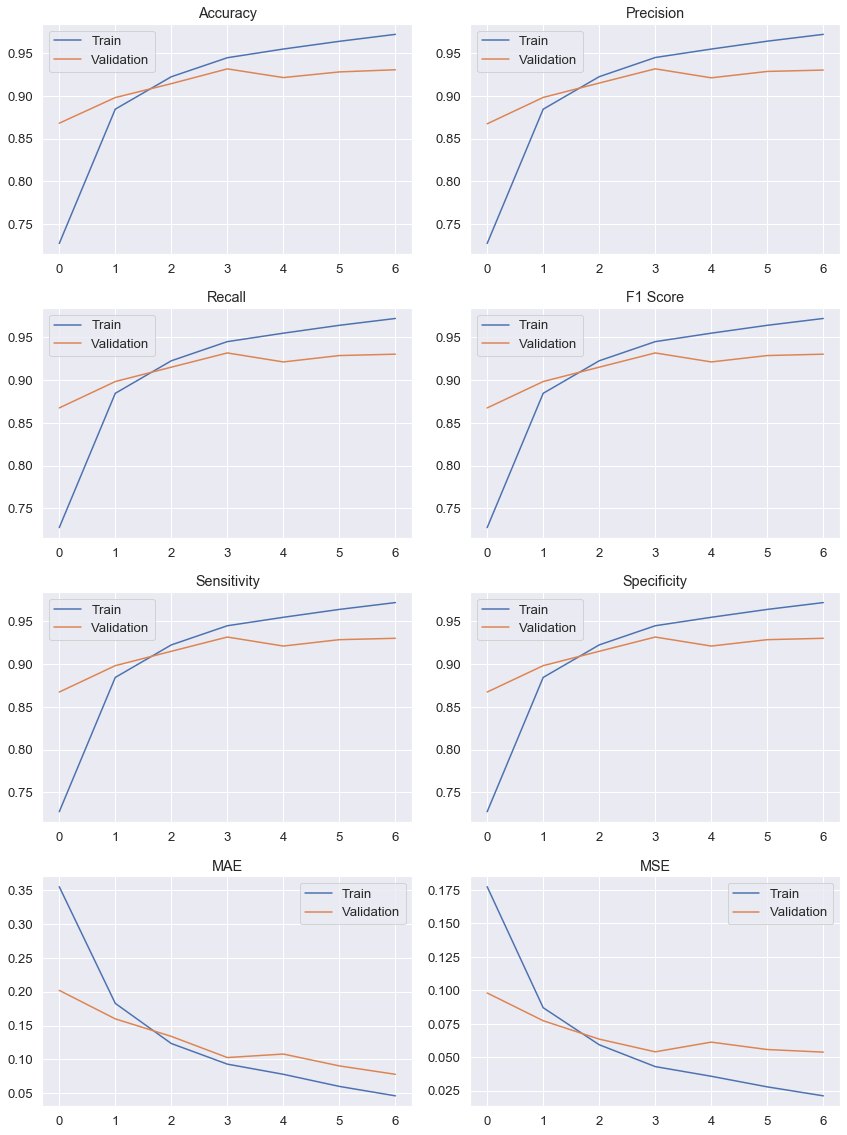

In [32]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

31/31 [==============================] - 1s 36ms/step - loss: 0.2309 - accuracy: 0.9308 - f1_score: 0.9303 - recall_m: 0.9303 - precision_m: 0.9303 - specificity_m: 0.9303 - sensitivity_m: 0.9303 - mae: 0.0780 - mse: 0.0538


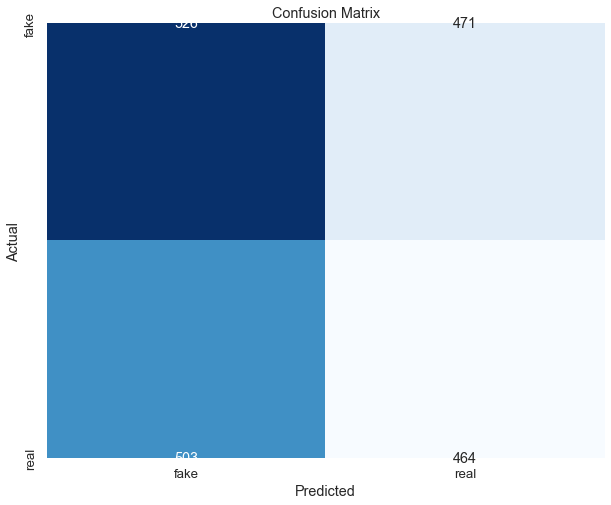

In [33]:
# Evaluate the model on the validation data
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes

# Retrieve class labels (class names) from the generator
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [34]:
a2 = history.history['accuracy'][-1]
f2 = history.history['f1_score'][-1]
p2 = history.history['precision_m'][-1]
r2 = history.history['recall_m'][-1]
mae2 = history.history['mae'][-1]
mse2 = history.history['mse'][-1]
specificity2 = history.history['specificity_m'][-1]  
sensitivity2 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a2 * 100))
print('Precision = ' + str(p2 * 100))
print('F1 Score = ' + str(f2 * 100))
print('Recall = ' + str(r2 * 100))
print('MAE = ' + str(mae2))
print('MSE = ' + str(mse2))
print('Sensitivity = ' + str(sensitivity2 * 100))  
print('Specificity = ' + str(specificity2 * 100))

Accuracy = 97.22293019294739
Precision = 97.21072912216187
F1 Score = 97.21072316169739
Recall = 97.21072912216187
MAE = 0.046275462955236435
MSE = 0.021048445254564285
Sensitivity = 97.21072912216187
Specificity = 97.21072912216187


# Xception

In [35]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)) 

In [36]:
inc = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [37]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
123/123 [==============================] - 14s 90ms/step - loss: 0.5682 - accuracy: 0.6562 - f1_score: 0.6557 - recall_m: 0.6557 - precision_m: 0.6557 - specificity_m: 0.6557 - sensitivity_m: 0.6557 - mae: 0.3937 - mse: 0.1968 - val_loss: 2.1159 - val_accuracy: 0.8534 - val_f1_score: 0.8528 - val_recall_m: 0.8528 - val_precision_m: 0.8528 - val_specificity_m: 0.8528 - val_sensitivity_m: 0.8528 - val_mae: 0.1492 - val_mse: 0.1370
Epoch 2/50
123/123 [==============================] - 10s 82ms/step - loss: 0.1419 - accuracy: 0.9461 - f1_score: 0.9461 - recall_m: 0.9461 - precision_m: 0.9461 - specificity_m: 0.9461 - sensitivity_m: 0.9461 - mae: 0.0868 - mse: 0.0413 - val_loss: 0.1537 - val_accuracy: 0.9496 - val_f1_score: 0.9490 - val_recall_m: 0.9490 - val_precision_m: 0.9490 - val_specificity_m: 0.9490 - val_sensitivity_m: 0.9490 - val_mae: 0.0623 - val_mse: 0.0409
Epoch 3/50
123/123 [==============================] - 10s 82ms/step - loss: 0.0550 - accuracy: 0.9810 - f1_score

In [38]:
model.save('models/Xception.h5')

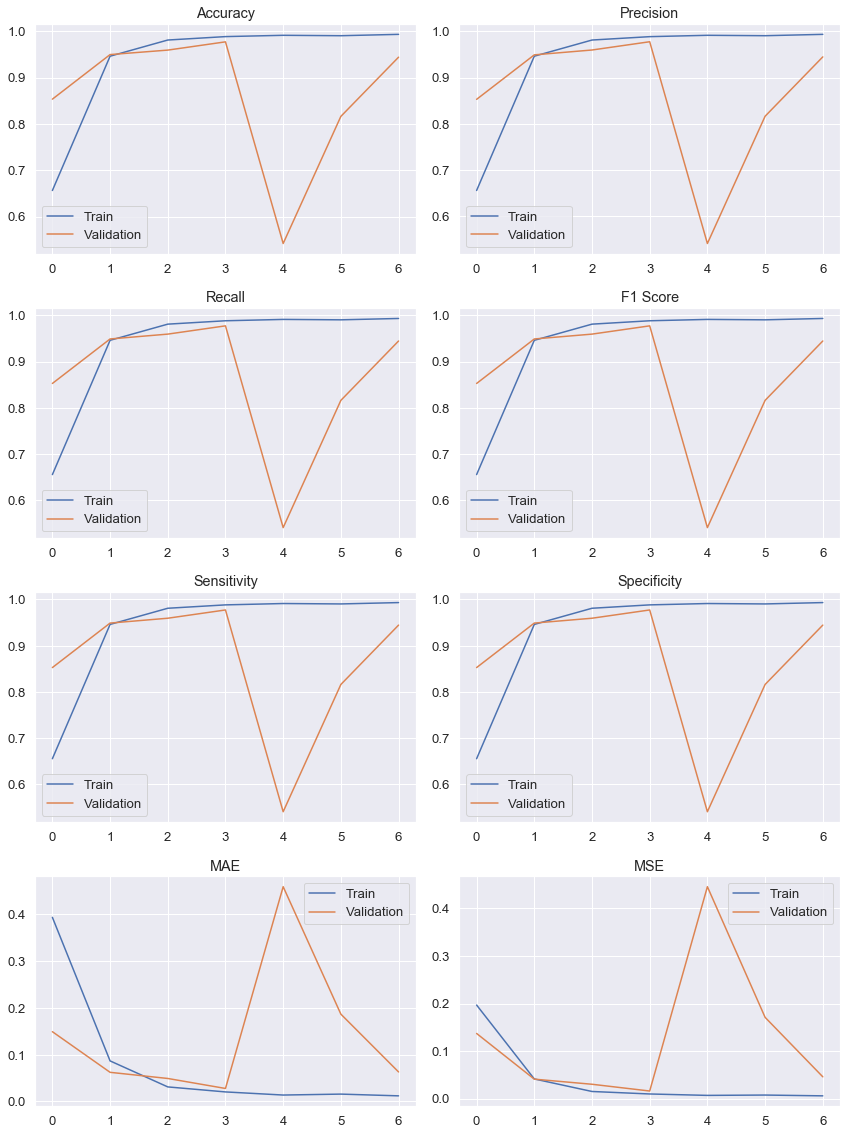

In [39]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

31/31 [==============================] - 1s 37ms/step - loss: 0.1883 - accuracy: 0.9440 - f1_score: 0.9436 - recall_m: 0.9436 - precision_m: 0.9436 - specificity_m: 0.9436 - sensitivity_m: 0.9436 - mae: 0.0638 - mse: 0.0464


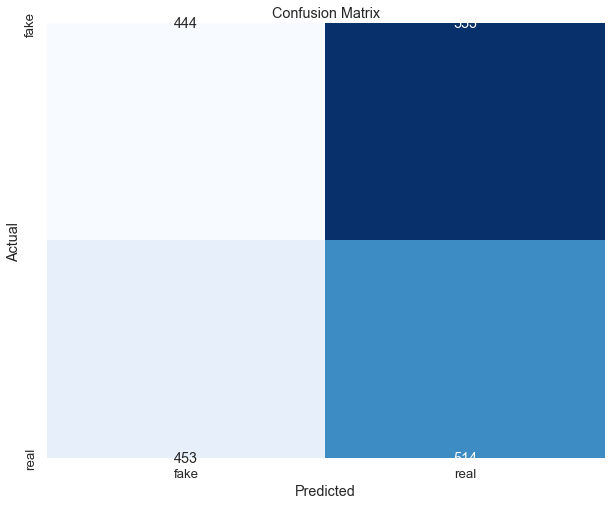

In [40]:
# Evaluate the model on the validation data
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes

# Retrieve class labels (class names) from the generator
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [41]:
a3 = history.history['accuracy'][-1]
f3 = history.history['f1_score'][-1]
p3 = history.history['precision_m'][-1]
r3 = history.history['recall_m'][-1]
mae3 = history.history['mae'][-1]
mse3 = history.history['mse'][-1]
specificity3 = history.history['specificity_m'][-1]  
sensitivity3 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a3 * 100))
print('Precision = ' + str(p3 * 100))
print('F1 Score = ' + str(f3 * 100))
print('Recall = ' + str(r3 * 100))
print('MAE = ' + str(mae3))
print('MSE = ' + str(mse3))
print('Sensitivity = ' + str(sensitivity3 * 100))  
print('Specificity = ' + str(specificity3 * 100))

Accuracy = 99.32484030723572
Precision = 99.3267297744751
F1 Score = 99.3267297744751
Recall = 99.3267297744751
MAE = 0.012060274370014668
MSE = 0.005787552800029516
Sensitivity = 99.3267297744751
Specificity = 99.3267297744751


# InceptionV3

In [42]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)) 

In [43]:
inc = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_209 (Conv2D)             (None, 63, 63, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_207 (BatchN (None, 63, 63, 32)   96          conv2d_209[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 63, 63, 32)   0           batch_normalization_207[0][0]    
____________________________________________________________________________________________

In [44]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
123/123 [==============================] - 12s 67ms/step - loss: 0.3872 - accuracy: 0.8711 - f1_score: 0.8712 - recall_m: 0.8712 - precision_m: 0.8712 - specificity_m: 0.8712 - sensitivity_m: 0.8712 - mae: 0.1980 - mse: 0.0981 - val_loss: 36.9483 - val_accuracy: 0.6838 - val_f1_score: 0.6845 - val_recall_m: 0.6845 - val_precision_m: 0.6845 - val_specificity_m: 0.6845 - val_sensitivity_m: 0.6845 - val_mae: 0.3159 - val_mse: 0.3146
Epoch 2/50
123/123 [==============================] - 7s 55ms/step - loss: 0.1270 - accuracy: 0.9546 - f1_score: 0.9547 - recall_m: 0.9547 - precision_m: 0.9547 - specificity_m: 0.9547 - sensitivity_m: 0.9547 - mae: 0.0725 - mse: 0.0354 - val_loss: 0.2121 - val_accuracy: 0.9318 - val_f1_score: 0.9320 - val_recall_m: 0.9320 - val_precision_m: 0.9320 - val_specificity_m: 0.9320 - val_sensitivity_m: 0.9320 - val_mae: 0.0729 - val_mse: 0.0536
Epoch 3/50
123/123 [==============================] - 7s 54ms/step - loss: 0.0634 - accuracy: 0.9757 - f1_score:

In [45]:
model.save('models/inceptionv3.h5')

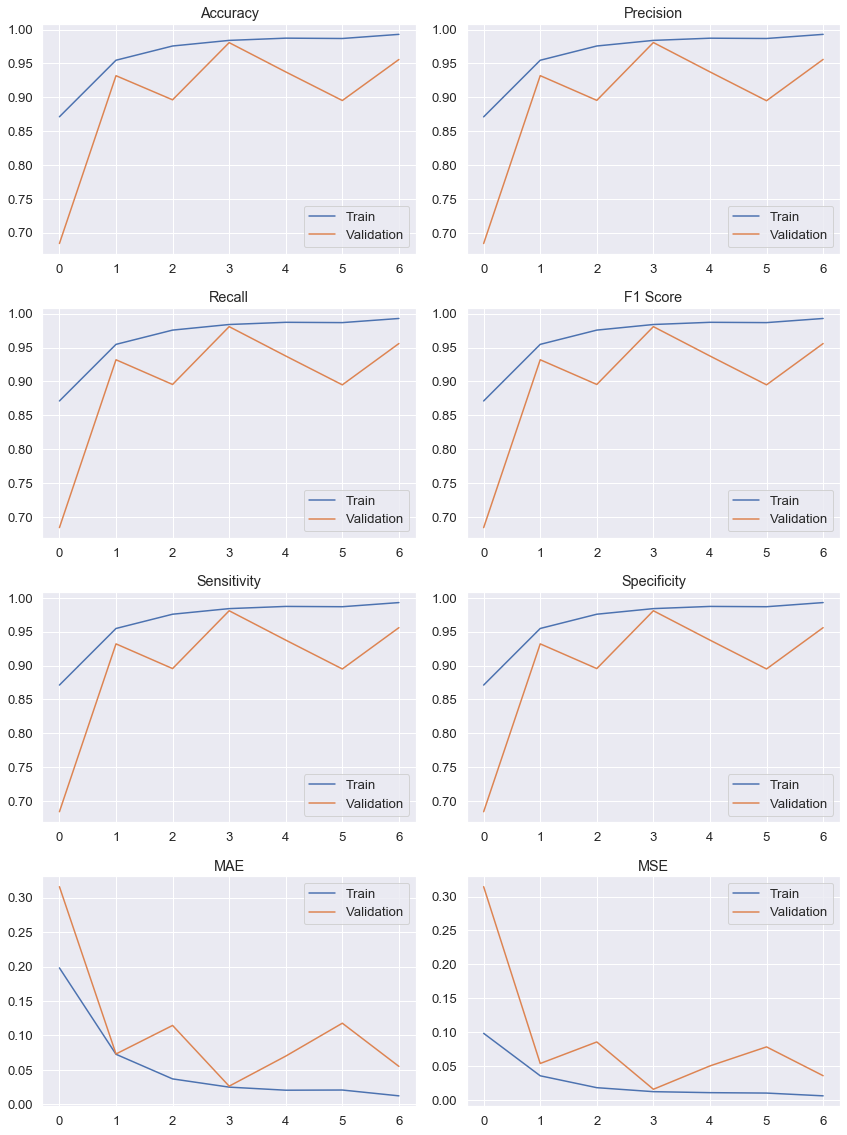

In [46]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

31/31 [==============================] - 1s 41ms/step - loss: 0.1440 - accuracy: 0.9557 - f1_score: 0.9561 - recall_m: 0.9561 - precision_m: 0.9561 - specificity_m: 0.9561 - sensitivity_m: 0.9561 - mae: 0.0547 - mse: 0.0353


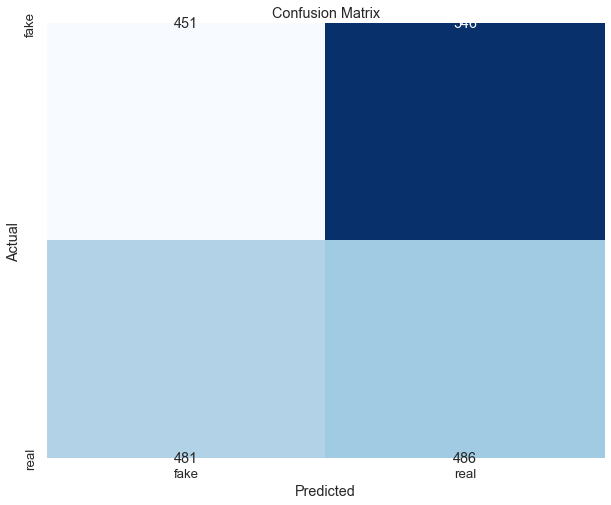

In [47]:
# Evaluate the model on the validation data
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes

# Retrieve class labels (class names) from the generator
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [48]:
a4 = history.history['accuracy'][-1]
f4 = history.history['f1_score'][-1]
p4 = history.history['precision_m'][-1]
r4 = history.history['recall_m'][-1]
mae4 = history.history['mae'][-1]
mse4 = history.history['mse'][-1]
specificity4 = history.history['specificity_m'][-1]  
sensitivity4 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a4 * 100))
print('Precision = ' + str(p4 * 100))
print('F1 Score = ' + str(f4 * 100))
print('Recall = ' + str(r4 * 100))
print('MAE = ' + str(mae4))
print('MSE = ' + str(mse4))
print('Sensitivity = ' + str(sensitivity4 * 100))  
print('Specificity = ' + str(specificity4 * 100))

Accuracy = 99.28662180900574
Precision = 99.28861856460571
F1 Score = 99.28861856460571
Recall = 99.28861856460571
MAE = 0.012126555666327477
MSE = 0.005822242237627506
Sensitivity = 99.28861856460571
Specificity = 99.28861856460571


# EfficientNetB1

In [49]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)) 

In [50]:
inc = tf.keras.applications.efficientnet.EfficientNetB1(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 128, 128, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 129, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [51]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
123/123 [==============================] - 20s 111ms/step - loss: 0.3498 - accuracy: 0.8940 - f1_score: 0.8938 - recall_m: 0.8938 - precision_m: 0.8938 - specificity_m: 0.8938 - sensitivity_m: 0.8938 - mae: 0.1269 - mse: 0.0848 - val_loss: 2.6185 - val_accuracy: 0.4924 - val_f1_score: 0.4936 - val_recall_m: 0.4936 - val_precision_m: 0.4936 - val_specificity_m: 0.4936 - val_sensitivity_m: 0.4936 - val_mae: 0.5063 - val_mse: 0.5006
Epoch 2/50
123/123 [==============================] - 12s 95ms/step - loss: 0.0721 - accuracy: 0.9718 - f1_score: 0.9719 - recall_m: 0.9719 - precision_m: 0.9719 - specificity_m: 0.9719 - sensitivity_m: 0.9719 - mae: 0.0380 - mse: 0.0204 - val_loss: 3.0514 - val_accuracy: 0.4924 - val_f1_score: 0.4915 - val_recall_m: 0.4915 - val_precision_m: 0.4915 - val_specificity_m: 0.4915 - val_sensitivity_m: 0.4915 - val_mae: 0.5083 - val_mse: 0.5059
Epoch 3/50
123/123 [==============================] - 11s 92ms/step - loss: 0.0565 - accuracy: 0.9803 - f1_scor

In [52]:
model.save('models/EfficientNetB1.h5')

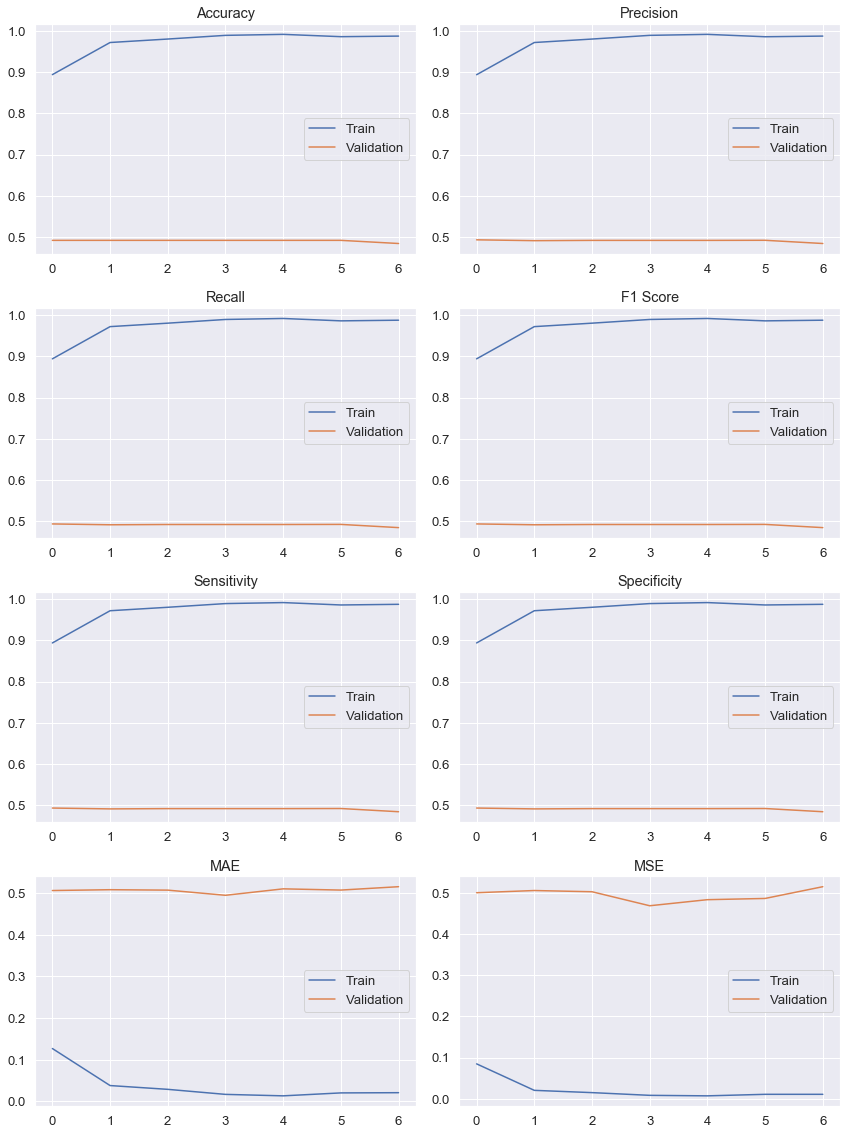

In [53]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

31/31 [==============================] - 1s 42ms/step - loss: 720.8256 - accuracy: 0.4837 - f1_score: 0.4832 - recall_m: 0.4832 - precision_m: 0.4832 - specificity_m: 0.4832 - sensitivity_m: 0.4832 - mae: 0.5171 - mse: 0.5169


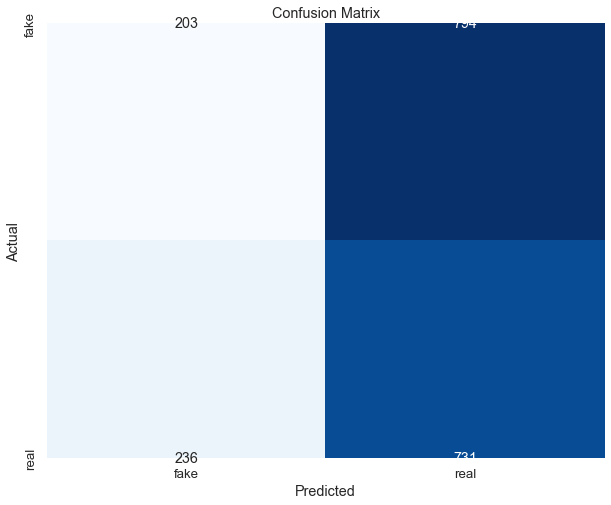

In [54]:
# Evaluate the model on the validation data
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes

# Retrieve class labels (class names) from the generator
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [55]:
a5 = history.history['accuracy'][-1]
f5 = history.history['f1_score'][-1]
p5 = history.history['precision_m'][-1]
r5 = history.history['recall_m'][-1]
mae5 = history.history['mae'][-1]
mse5 = history.history['mse'][-1]
specificity5 = history.history['specificity_m'][-1]  
sensitivity5 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a5 * 100))
print('Precision = ' + str(p5 * 100))
print('F1 Score = ' + str(f5 * 100))
print('Recall = ' + str(r5 * 100))
print('MAE = ' + str(mae5))
print('MSE = ' + str(mse5))
print('Sensitivity = ' + str(sensitivity5 * 100))  
print('Specificity = ' + str(specificity5 * 100))

Accuracy = 98.7388551235199
Precision = 98.74237775802612
F1 Score = 98.74237775802612
Recall = 98.74237775802612
MAE = 0.020828066393733025
MSE = 0.010758863762021065
Sensitivity = 98.74237775802612
Specificity = 98.74237775802612


# DenseNet 121

In [56]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)) 

In [57]:
inc = tf.keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [58]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
123/123 [==============================] - 15s 78ms/step - loss: 0.3617 - accuracy: 0.8897 - f1_score: 0.8897 - recall_m: 0.8897 - precision_m: 0.8897 - specificity_m: 0.8897 - sensitivity_m: 0.8897 - mae: 0.1396 - mse: 0.0846 - val_loss: 2.8209 - val_accuracy: 0.6309 - val_f1_score: 0.6300 - val_recall_m: 0.6300 - val_precision_m: 0.6300 - val_specificity_m: 0.6300 - val_sensitivity_m: 0.6300 - val_mae: 0.3635 - val_mse: 0.3365
Epoch 2/50
123/123 [==============================] - 7s 57ms/step - loss: 0.1244 - accuracy: 0.9567 - f1_score: 0.9566 - recall_m: 0.9566 - precision_m: 0.9566 - specificity_m: 0.9566 - sensitivity_m: 0.9566 - mae: 0.0644 - mse: 0.0332 - val_loss: 2.6946 - val_accuracy: 0.6965 - val_f1_score: 0.6957 - val_recall_m: 0.6957 - val_precision_m: 0.6957 - val_specificity_m: 0.6957 - val_sensitivity_m: 0.6957 - val_mae: 0.3035 - val_mse: 0.2747
Epoch 3/50
123/123 [==============================] - 7s 58ms/step - loss: 0.0792 - accuracy: 0.9687 - f1_score: 

In [59]:
model.save('models/DenseNet121.h5')

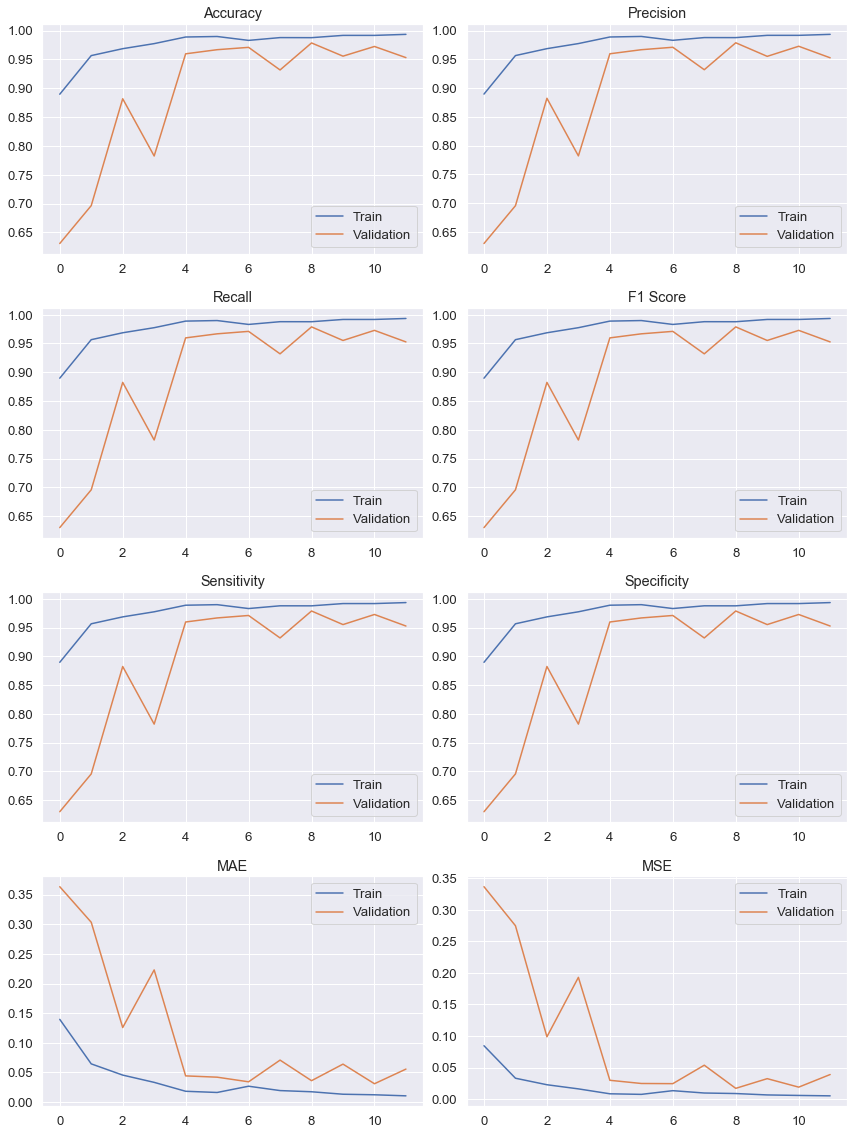

In [60]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

31/31 [==============================] - 1s 42ms/step - loss: 0.1667 - accuracy: 0.9532 - f1_score: 0.9532 - recall_m: 0.9532 - precision_m: 0.9532 - specificity_m: 0.9532 - sensitivity_m: 0.9532 - mae: 0.0551 - mse: 0.0386


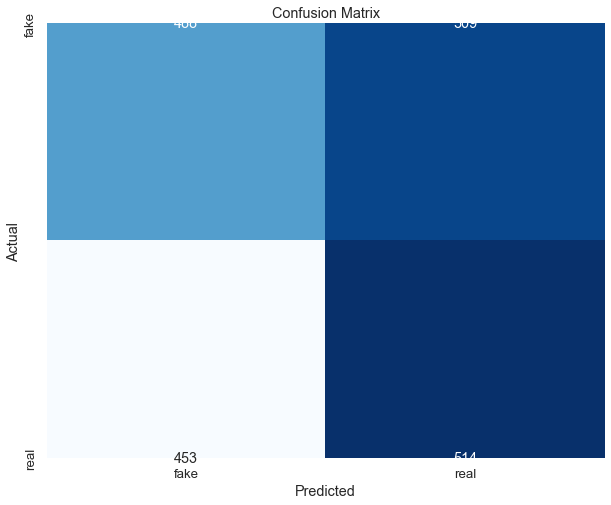

In [61]:
# Evaluate the model on the validation data
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes

# Retrieve class labels (class names) from the generator
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [62]:
a6 = history.history['accuracy'][-1]
f6 = history.history['f1_score'][-1]
p6 = history.history['precision_m'][-1]
r6 = history.history['recall_m'][-1]
mae6 = history.history['mae'][-1]
mse6 = history.history['mse'][-1]
specificity6 = history.history['specificity_m'][-1]  
sensitivity6 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a6 * 100))
print('Precision = ' + str(p6 * 100))
print('F1 Score = ' + str(f6 * 100))
print('Recall = ' + str(r6 * 100))
print('MAE = ' + str(mae6))
print('MSE = ' + str(mse6))
print('Sensitivity = ' + str(sensitivity6 * 100))  
print('Specificity = ' + str(specificity6 * 100))

Accuracy = 99.3503212928772
Precision = 99.34548139572144
F1 Score = 99.34548139572144
Recall = 99.34548139572144
MAE = 0.010442418046295643
MSE = 0.005295386537909508
Sensitivity = 99.34548139572144
Specificity = 99.34548139572144


# Hybrid Algorithms

In [63]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)) 

In [64]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Average
import efficientnet.keras 
def ensemble():

    model_1 = load_model('models/Xception.h5', compile=False)
    model_1 = Model(inputs = model_1.inputs, outputs = model_1.outputs, name = 'Xception')

    model_2 = load_model('models/Inceptionresnet_v2.h5', compile=False)
    model_2 = Model(inputs = model_2.inputs, outputs = model_2.outputs, name = 'Inception')
    
    models = [model_1, model_2]


    models_input = Input(shape =(128,128,3))
    models_output = [model(models_input) for model in models]
    
    ensemble_output = Average()(models_output)

    simple_average = Model(inputs = models_input, outputs = ensemble_output, name = 'Ensemble')

    return simple_average

Using TensorFlow backend.


In [65]:
model = ensemble()
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
123/123 [==============================] - 30s 170ms/step - loss: 0.0757 - accuracy: 0.9688 - f1_score: 0.9661 - recall_m: 0.9632 - precision_m: 0.9691 - specificity_m: 0.9632 - sensitivity_m: 0.9632 - mae: 0.0511 - mse: 0.0230 - val_loss: 0.6315 - val_accuracy: 0.8753 - val_f1_score: 0.7549 - val_recall_m: 0.6713 - val_precision_m: 0.8651 - val_specificity_m: 0.6703 - val_sensitivity_m: 0.6713 - val_mae: 0.2851 - val_mse: 0.1481
Epoch 2/50
123/123 [==============================] - 19s 153ms/step - loss: 0.0697 - accuracy: 0.9762 - f1_score: 0.9730 - recall_m: 0.9699 - precision_m: 0.9762 - specificity_m: 0.9699 - sensitivity_m: 0.9699 - mae: 0.0473 - mse: 0.0210 - val_loss: 0.3309 - val_accuracy: 0.8819 - val_f1_score: 0.8767 - val_recall_m: 0.8720 - val_precision_m: 0.8815 - val_specificity_m: 0.8720 - val_sensitivity_m: 0.8720 - val_mae: 0.1287 - val_mse: 0.0755
Epoch 3/50
123/123 [==============================] - 19s 155ms/step - loss: 0.0572 - accuracy: 0.9834 - f1_sc

In [66]:
model.save('models/Hybrid.h5')

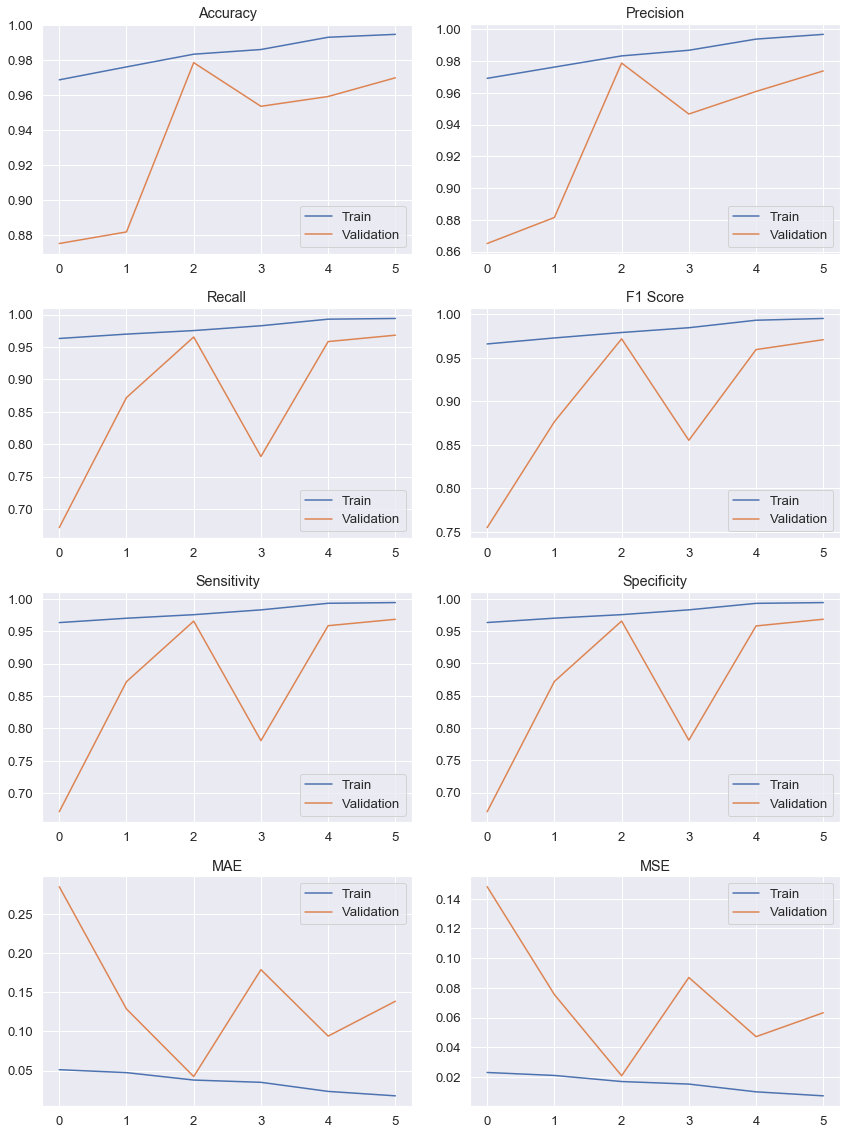

In [67]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

31/31 [==============================] - 2s 46ms/step - loss: 0.1943 - accuracy: 0.9700 - f1_score: 0.9714 - recall_m: 0.9688 - precision_m: 0.9740 - specificity_m: 0.9688 - sensitivity_m: 0.9688 - mae: 0.1380 - mse: 0.0629


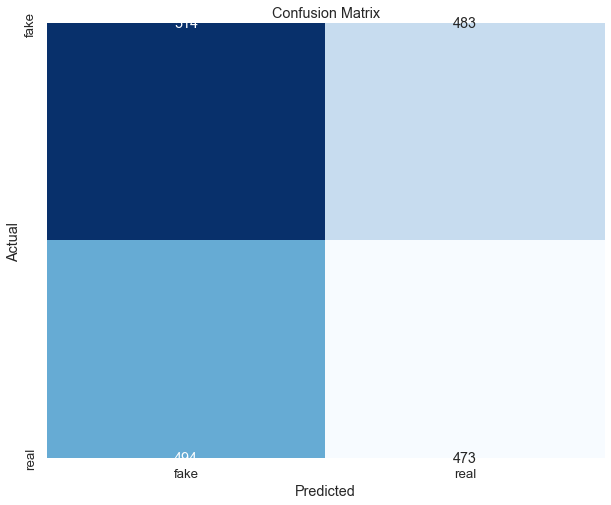

In [68]:
# Evaluate the model on the validation data
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes

# Retrieve class labels (class names) from the generator
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [69]:
a7 = history.history['accuracy'][-1]
f7 = history.history['f1_score'][-1]
p7 = history.history['precision_m'][-1]
r7 = history.history['recall_m'][-1]
mae7 = history.history['mae'][-1]
mse7 = history.history['mse'][-1]
specificity7 = history.history['specificity_m'][-1]  
sensitivity7 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a7 * 100))
print('Precision = ' + str(p7 * 100))
print('F1 Score = ' + str(f7 * 100))
print('Recall = ' + str(r7 * 100))
print('MAE = ' + str(mae7))
print('MSE = ' + str(mse7))
print('Sensitivity = ' + str(sensitivity7 * 100))  
print('Specificity = ' + str(specificity7 * 100))

Accuracy = 99.47770833969116
Precision = 99.67535734176636
F1 Score = 99.54062104225159
Recall = 99.40899610519409
MAE = 0.017596933990716934
MSE = 0.007278527598828077
Sensitivity = 99.40899610519409
Specificity = 99.40899610519409


# LSTM

In [70]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)) 

In [71]:
labels = ['fake','real']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [72]:
train = get_data(r"output/train")
val = get_data(r"output/val")

In [73]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("fake")
    else:
        l.append("real")

In [74]:
a = []
for i in val:
    if(i[1] == 0):
        a.append("fake")
    else:
        a.append("real")

In [75]:
x_train = []
y_train = []
x_val = []
y_val = []


for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [76]:
print("x_train:",x_train.shape)
print("y_train:",y_train.shape)
print("x_val:",x_val.shape)
print("y_val:",y_val.shape)

x_train: (7850, 150, 150, 3)
y_train: (7850,)
x_val: (1964, 150, 150, 3)
y_val: (1964,)


In [77]:
datagen = ImageDataGenerator(
       featurewise_center=False,  
       samplewise_center=False,  
       featurewise_std_normalization=False,  
       samplewise_std_normalization=False,  
       zca_whitening=False,  
       rotation_range = 90, 
       zoom_range = 0.5, 
       width_shift_range=0.2,  
       height_shift_range=0.2,  
       horizontal_flip = True,  
       
)


datagen.fit(x_train)
datagen.fit(x_val)

In [78]:
x_train = np.array(x_train).reshape(7850,1,150,150, 3)
x_val = np.array(x_val).reshape(1964,1,150,150, 3)

In [79]:
model = Sequential()
model.add(TimeDistributed(Conv2D(64,(3,3),activation='relu'),input_shape=(1,150,150,3)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

model.add(TimeDistributed(Conv2D(32,(3,3),activation='relu')))

model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=False))

model.add(Dense(1,activation='sigmoid'))

In [80]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 1, 148, 148, 64)   1792      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 74, 74, 64)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 72, 72, 32)     18464     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 36, 36, 32)     0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 41472)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               16629200  
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [81]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(x_train,y_train, validation_data=(x_val, y_val), epochs=50,  callbacks=[early_stopping_callback])

Epoch 1/50
246/246 [==============================] - 4s 12ms/step - loss: 0.0000e+00 - accuracy: 0.5087 - f1_score: 0.0031 - recall_m: 0.0039 - precision_m: 0.0026 - specificity_m: 0.9959 - sensitivity_m: 0.0039 - mae: 0.4917 - mse: 0.4903 - val_loss: 0.0000e+00 - val_accuracy: 0.5076 - val_f1_score: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_specificity_m: 0.5161 - val_sensitivity_m: 0.0000e+00 - val_mae: 0.4975 - val_mse: 0.4975
Epoch 2/50
246/246 [==============================] - 2s 10ms/step - loss: 0.0000e+00 - accuracy: 0.5075 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.4922 - mse: 0.4922 - val_loss: 0.0000e+00 - val_accuracy: 0.5076 - val_f1_score: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_specificity_m: 0.5161 - val_sensitivity_m: 0.0000e+00 - val_mae: 0.4975 - val_mse: 0.4975
Epoch 3/50
246/246 [==============================

In [82]:
model.save('models/lstm.h5')

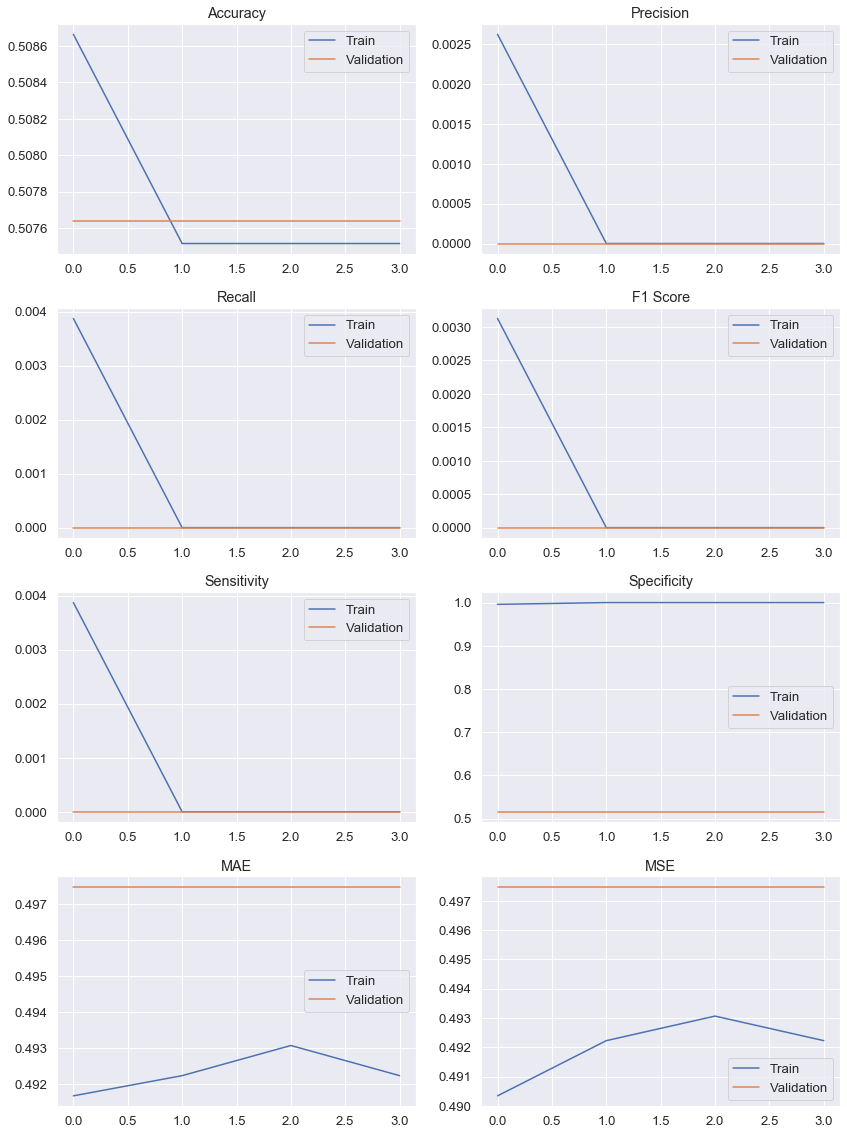

In [83]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

1964/1964 [==============================] - 2s 763us/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 0.0000e+00 - sensitivity_m: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00


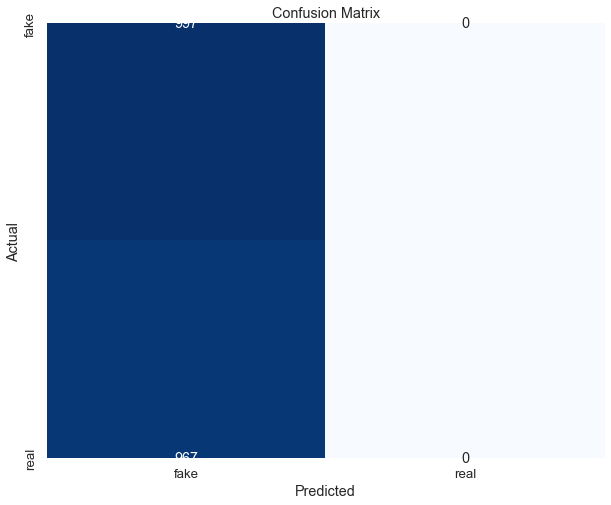

In [84]:
# Evaluate the model on the validation data
val_evaluation = model.evaluate(x_val, steps=len(x_val))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(x_val)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes

# Retrieve class labels (class names) from the generator
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [85]:
a8 = history.history['accuracy'][-1]
f8 = history.history['f1_score'][-1]
p8 = history.history['precision_m'][-1]
r8 = history.history['recall_m'][-1]
mae8 = history.history['mae'][-1]
mse8 = history.history['mse'][-1]
specificity8 = history.history['specificity_m'][-1]  
sensitivity8 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a8 * 100))
print('Precision = ' + str(p8 * 100))
print('F1 Score = ' + str(f8 * 100))
print('Recall = ' + str(r8 * 100))
print('MAE = ' + str(mae8))
print('MSE = ' + str(mse8))
print('Sensitivity = ' + str(sensitivity8 * 100))  
print('Specificity = ' + str(specificity8 * 100))

Accuracy = 50.751590728759766
Precision = 0.0
F1 Score = 0.0
Recall = 0.0
MAE = 0.49222561717033386
MSE = 0.49222561717033386
Sensitivity = 0.0
Specificity = 100.0


# ResNext + LSTM

In [86]:
# Define a ResNet block function
def resnet_block(input_layer):
    # Example ResNet block
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    resnet_output = conv2  
    return resnet_output


def create_resnet_lstm_model(input_shape, timesteps):
    input_layer = Input(shape=input_shape)
    
    # Apply ResNet block
    resnet_output = resnet_block(input_layer)
    
    # Reshape before LSTM
    reshaped_output = Reshape((timesteps, -1))(resnet_output)
    
    # Apply LSTM layer
    lstm_output = LSTM(1, return_sequences=False)(reshaped_output)
    
    model = Model(inputs=input_layer, outputs=lstm_output)
    
    return model


input_shape = (1,150, 150, 3)
timesteps = 10  

# Create the ResNet + LSTM model
model = create_resnet_lstm_model(input_shape, timesteps)

In [87]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1, 150, 150, 3)]  0         
_________________________________________________________________
conv2d_305 (Conv2D)          (None, 1, 150, 150, 64)   1792      
_________________________________________________________________
conv2d_306 (Conv2D)          (None, 1, 150, 150, 64)   36928     
_________________________________________________________________
reshape (Reshape)            (None, 10, 144000)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1)                 576008    
Total params: 614,728
Trainable params: 614,728
Non-trainable params: 0
_________________________________________________________________


In [88]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(x_train,y_train, validation_data=(x_val, y_val), epochs=50,  callbacks=[early_stopping_callback])

Epoch 1/50
246/246 [==============================] - 8s 23ms/step - loss: 5.8709e-08 - accuracy: 0.5075 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.6213 - mse: 0.6395 - val_loss: 5.8694e-08 - val_accuracy: 0.5076 - val_f1_score: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_specificity_m: 0.5161 - val_sensitivity_m: 0.0000e+00 - val_mae: 0.6249 - val_mse: 0.6435
Epoch 2/50
246/246 [==============================] - 5s 21ms/step - loss: 5.8709e-08 - accuracy: 0.5075 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.6209 - mse: 0.6391 - val_loss: 5.8694e-08 - val_accuracy: 0.5076 - val_f1_score: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_specificity_m: 0.5161 - val_sensitivity_m: 0.0000e+00 - val_mae: 0.6249 - val_mse: 0.6435
Epoch 3/50
246/246 [==============

In [89]:
model.save('models/resnext+lstm.h5')

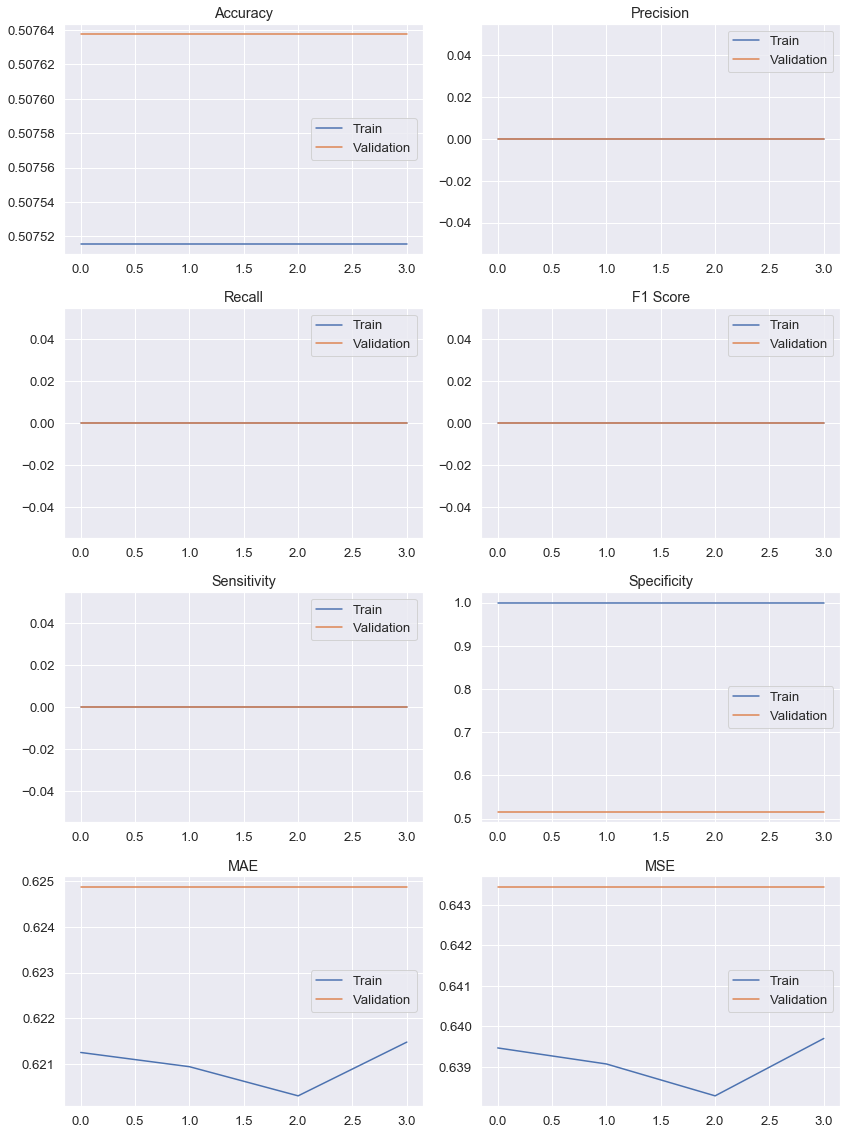

In [90]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

1964/1964 [==============================] - 2s 739us/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 0.0000e+00 - sensitivity_m: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00


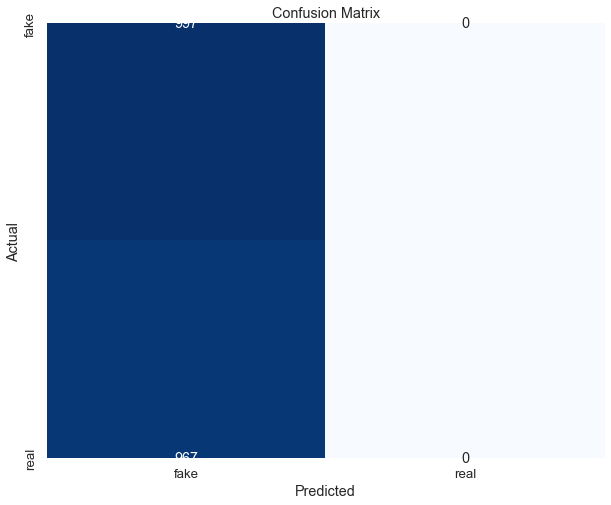

In [91]:
# Evaluate the model on the validation data
val_evaluation = model.evaluate(x_val, steps=len(x_val))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(x_val)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes

# Retrieve class labels (class names) from the generator
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [92]:
a9 = history.history['accuracy'][-1]
f9 = history.history['f1_score'][-1]
p9 = history.history['precision_m'][-1]
r9 = history.history['recall_m'][-1]
mae9 = history.history['mae'][-1]
mse9 = history.history['mse'][-1]
specificity9 = history.history['specificity_m'][-1]  
sensitivity9 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a9 * 100))
print('Precision = ' + str(p9 * 100))
print('F1 Score = ' + str(f9 * 100))
print('Recall = ' + str(r9 * 100))
print('MAE = ' + str(mae9))
print('MSE = ' + str(mse9))
print('Sensitivity = ' + str(sensitivity9 * 100))  
print('Specificity = ' + str(specificity9 * 100))

Accuracy = 50.751590728759766
Precision = 0.0
F1 Score = 0.0
Recall = 0.0
MAE = 0.6214801669120789
MSE = 0.639702320098877
Sensitivity = 0.0
Specificity = 100.0


# MRI-GAN

In [93]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)) 

In [94]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128 * 7 * 7, activation='relu', input_dim=100),
    tf.keras.layers.Reshape((7, 7, 128)),
    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='sigmoid')
])

# Discriminator model
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, input_shape=(128, 128, 3), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the discriminator
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Combined GAN model
model = tf.keras.Sequential([generator, discriminator])
discriminator.trainable = False

In [95]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
123/123 [==============================] - 7s 51ms/step - loss: 0.5114 - accuracy: 0.7382 - f1_score: 0.7382 - recall_m: 0.7382 - precision_m: 0.7382 - specificity_m: 0.7382 - sensitivity_m: 0.7382 - mae: 0.3407 - mse: 0.1703 - val_loss: 0.3688 - val_accuracy: 0.8483 - val_f1_score: 0.8473 - val_recall_m: 0.8473 - val_precision_m: 0.8473 - val_specificity_m: 0.8473 - val_sensitivity_m: 0.8473 - val_mae: 0.2575 - val_mse: 0.1158
Epoch 2/50
123/123 [==============================] - 6s 49ms/step - loss: 0.3239 - accuracy: 0.8647 - f1_score: 0.8648 - recall_m: 0.8648 - precision_m: 0.8648 - specificity_m: 0.8648 - sensitivity_m: 0.8648 - mae: 0.2060 - mse: 0.1000 - val_loss: 0.2847 - val_accuracy: 0.8875 - val_f1_score: 0.8870 - val_recall_m: 0.8870 - val_precision_m: 0.8870 - val_specificity_m: 0.8870 - val_sensitivity_m: 0.8870 - val_mae: 0.1843 - val_mse: 0.0868
Epoch 3/50
123/123 [==============================] - 6s 48ms/step - loss: 0.2508 - accuracy: 0.9005 - f1_score: 0

In [96]:
model.save('models/mri-gan.h5')

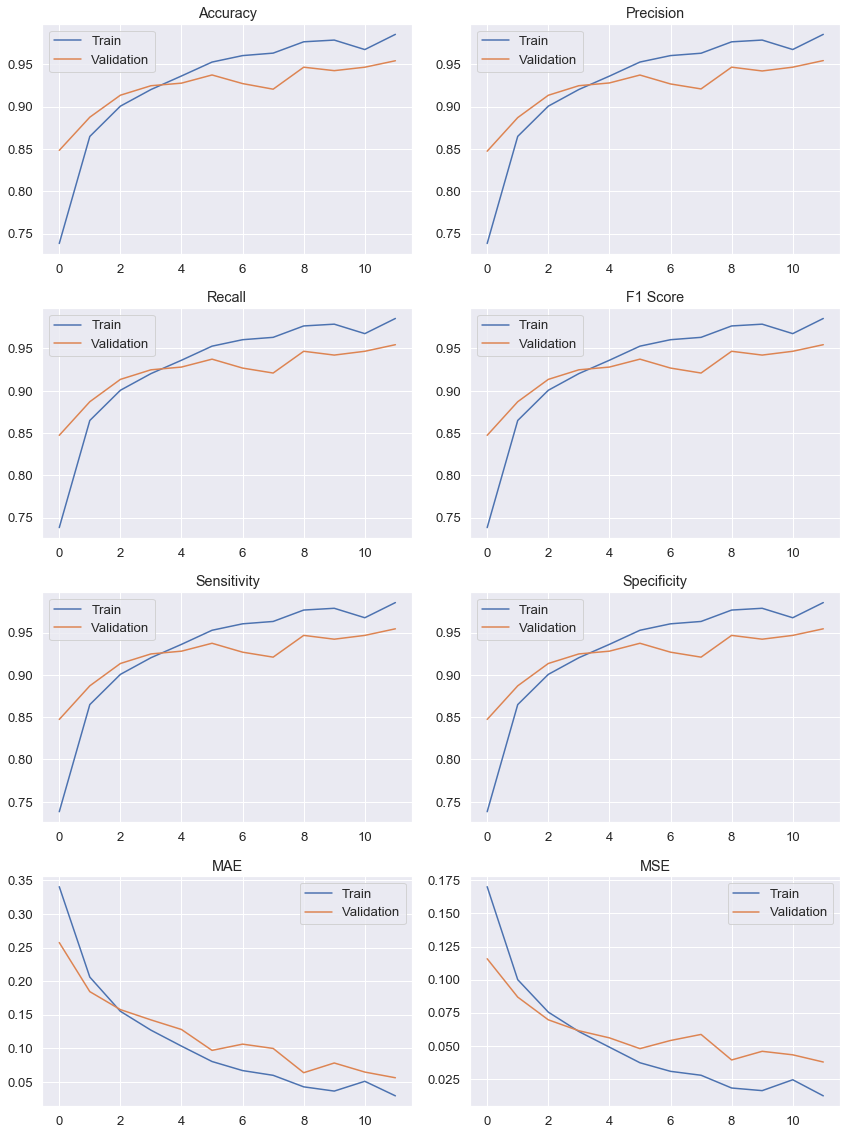

In [97]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

31/31 [==============================] - 1s 38ms/step - loss: 0.1687 - accuracy: 0.9542 - f1_score: 0.9533 - recall_m: 0.9533 - precision_m: 0.9533 - specificity_m: 0.9533 - sensitivity_m: 0.9533 - mae: 0.0570 - mse: 0.0385


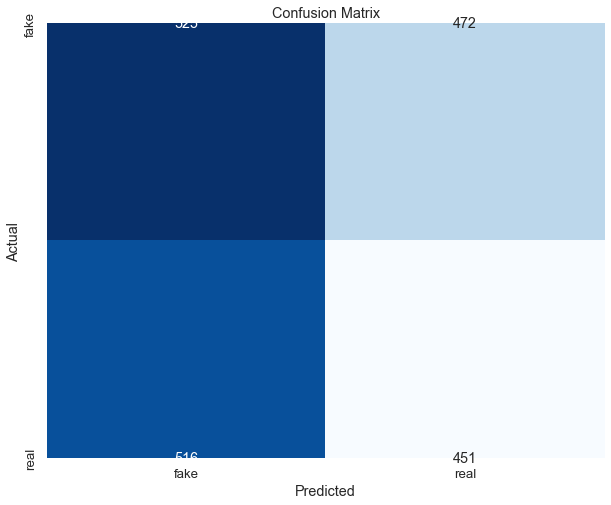

In [99]:
# Evaluate the model on the validation data
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes

# Retrieve class labels (class names) from the generator
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [100]:
a10 = history.history['accuracy'][-1]
f10 = history.history['f1_score'][-1]
p10 = history.history['precision_m'][-1]
r10 = history.history['recall_m'][-1]
mae10 = history.history['mae'][-1]
mse10 = history.history['mse'][-1]
specificity10 = history.history['specificity_m'][-1]  
sensitivity10 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a10 * 100))
print('Precision = ' + str(p10 * 100))
print('F1 Score = ' + str(f10 * 100))
print('Recall = ' + str(r10 * 100))
print('MAE = ' + str(mae10))
print('MSE = ' + str(mse10))
print('Sensitivity = ' + str(sensitivity10 * 100))  
print('Specificity = ' + str(specificity10 * 100))

Accuracy = 98.53503108024597
Precision = 98.53912591934204
F1 Score = 98.53912591934204
Recall = 98.53912591934204
MAE = 0.029024578630924225
MSE = 0.012098127044737339
Sensitivity = 98.53912591934204
Specificity = 98.53912591934204


# Comparison

In [101]:
a = 0.9898089170455933
results ={'Accuracy': [a,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10],
 'Recall':[r,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10],
 'Precision': [p,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10],
  'F1 Score' : [f,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10],
    'Sensitivity' : [sensitivity,sensitivity1,sensitivity2,sensitivity3,sensitivity4,sensitivity5,sensitivity6,sensitivity7,sensitivity8,sensitivity9,sensitivity10],
    'Specificity' : [specificity,specificity1,specificity2,specificity3,specificity4,specificity5,specificity6,specificity7,specificity8,specificity9,specificity10],
   'MAE' : [mae,mae1,mae2,mae3,mae4,mae5,mae6,mae7,mae8,mae9,mae10],
    'MSE' : [mse,mse1,mse2,mse3,mse4,mse5,mse6,mse7,mse8,mse9,mse10]}
index = ['InceptionResnet V2','VGG19','CNN','Xception','InceptionV3','EfficientNetB1','DenseNet121','Hybrid Model','LSTM','ResNext - LSTM','MRI-GAN']

In [102]:
results =pd.DataFrame(results,index=index)

In [103]:
print(results)

                    Accuracy    Recall  Precision  F1 Score  Sensitivity  \
InceptionResnet V2  0.989809  0.989837   0.989837  0.989837     0.989837   
VGG19               0.505987  0.505904   0.505904  0.505904     0.505904   
CNN                 0.972229  0.972107   0.972107  0.972107     0.972107   
Xception            0.993248  0.993267   0.993267  0.993267     0.993267   
InceptionV3         0.992866  0.992886   0.992886  0.992886     0.992886   
EfficientNetB1      0.987389  0.987424   0.987424  0.987424     0.987424   
DenseNet121         0.993503  0.993455   0.993455  0.993455     0.993455   
Hybrid Model        0.994777  0.994090   0.996754  0.995406     0.994090   
LSTM                0.507516  0.000000   0.000000  0.000000     0.000000   
ResNext - LSTM      0.507516  0.000000   0.000000  0.000000     0.000000   
MRI-GAN             0.985350  0.985391   0.985391  0.985391     0.985391   

                    Specificity                                   MAE  \
InceptionResne

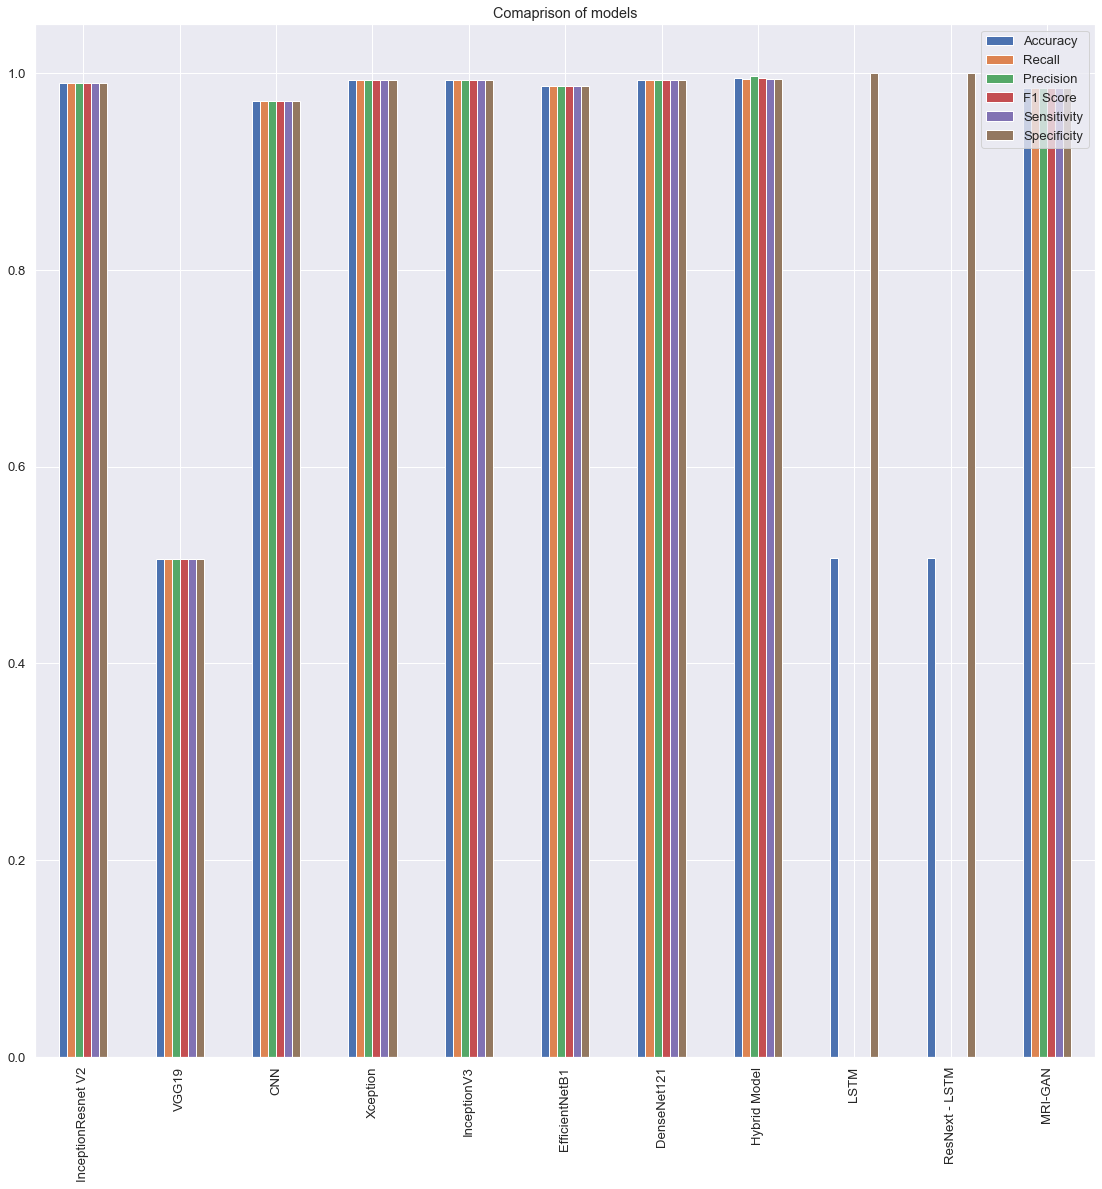

In [104]:
fig =results.plot(kind='bar',title='Comaprison of models',figsize =(19,19)).get_figure()
fig.savefig('Final Result.png')

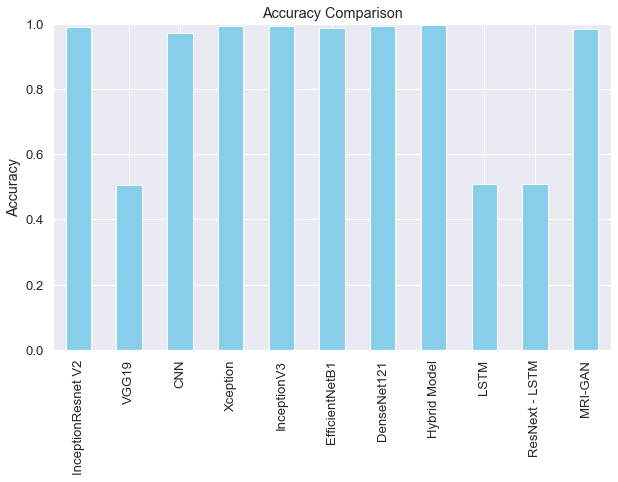

In [105]:
results_df = pd.DataFrame(results, index = ['InceptionResnet V2','VGG19','CNN','Xception','InceptionV3','EfficientNetB1','DenseNet121','Hybrid Model','LSTM','ResNext - LSTM','MRI-GAN'])

# Plotting Accuracy
plt.figure(figsize=(10, 6))
results_df['Accuracy'].plot(kind='bar', color='skyblue')
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

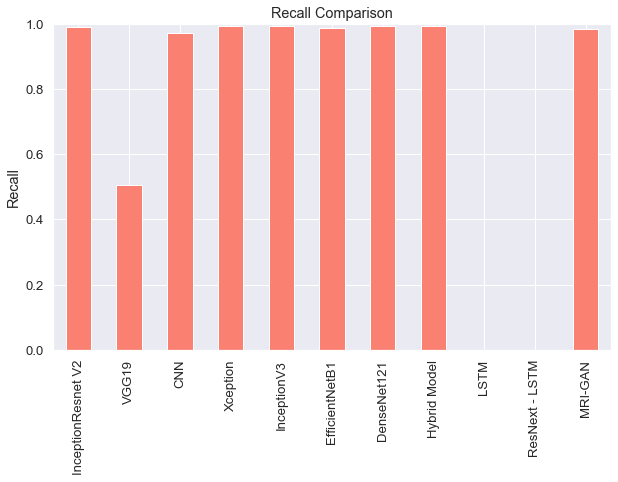

In [106]:
plt.figure(figsize=(10, 6))
results_df['Recall'].plot(kind='bar', color='salmon')
plt.title('Recall Comparison')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.show()

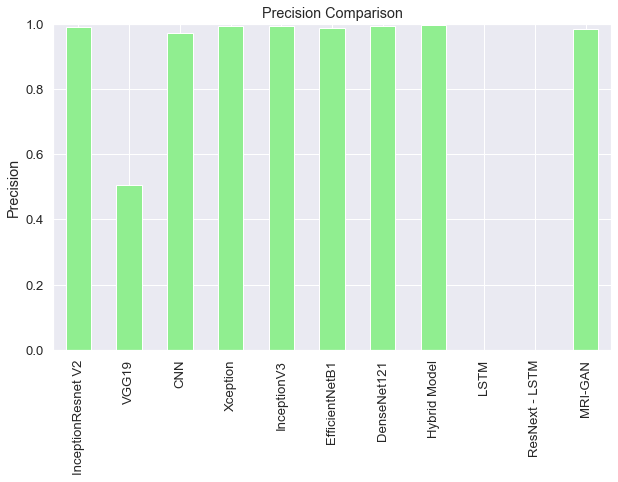

In [107]:
plt.figure(figsize=(10, 6))
results_df['Precision'].plot(kind='bar', color='lightgreen')
plt.title('Precision Comparison')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.show()

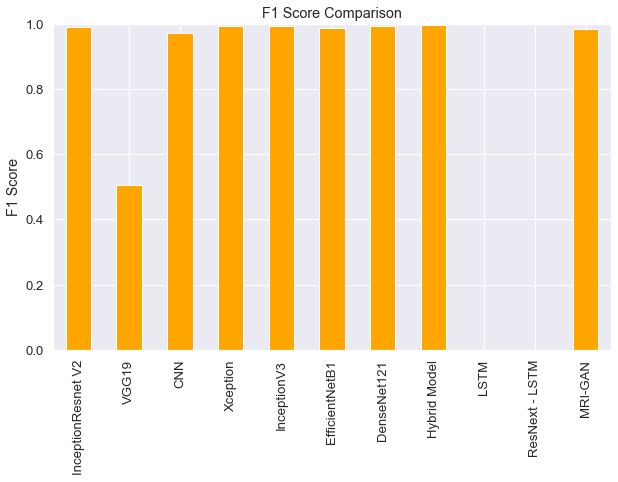

In [108]:
plt.figure(figsize=(10, 6))
results_df['F1 Score'].plot(kind='bar', color='orange')
plt.title('F1 Score Comparison')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()

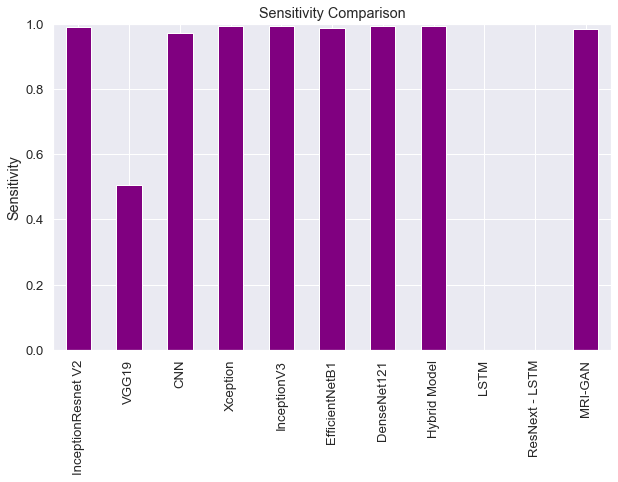

In [109]:
plt.figure(figsize=(10, 6))
results_df['Sensitivity'].plot(kind='bar', color='purple')
plt.title('Sensitivity Comparison')
plt.ylabel('Sensitivity')
plt.ylim(0, 1)
plt.show()

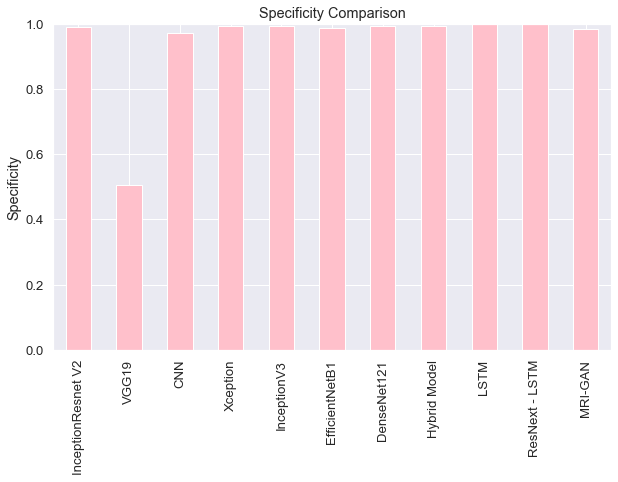

In [110]:
plt.figure(figsize=(10, 6))
results_df['Specificity'].plot(kind='bar', color='pink')
plt.title('Specificity Comparison')
plt.ylabel('Specificity')
plt.ylim(0, 1)
plt.show()